This notebook runs various clustering algorithms to try and understand contextual embeddings generated by a pretrained DistilBERT model on IMDB reviews dataset

In [222]:
import pandas as pd
import numpy as np
import time, json
import matplotlib.pyplot as plt
import seaborn as sns

import os, pickle
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak")

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

from transformers import AutoTokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [4]:
root_dir = '../../nlp/text_classification/local/distillBERT_inference_imdb_sentiment/'

roots_with_data = []
for root, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.pkl'):
            roots_with_data.append(root)
            break
print (len(roots_with_data))


10


In [5]:
# process a root dir

root_dir_idx = 0
for root_dir_idx in range(len(roots_with_data)):
    start_time = time.time()
    sentence_pdf = []
    token_pdf = []
    embeddings_lookup_pdf = []
    concatenated_embeddings = []
    num_files_processed = 0
    for _, _, files in os.walk(roots_with_data[root_dir_idx]):
        for file in files:
            if file.endswith('.pkl'):
                batch = []
                with open(os.path.join(roots_with_data[root_dir_idx], file), 'rb') as f:
                    batch = pickle.load(f)
                for row in batch:
                    num_tokens = row['last_hidden_state'].shape[0]
                    input_ids = row['input_ids'][:num_tokens]
                    tokens = tokenizer.convert_ids_to_tokens(input_ids)
                    sentence_id = f"{root_dir_idx}-{len(sentence_pdf)}"
                    sentence_pdf.append((sentence_id, row['text'], row['label'], input_ids, tokens))
                    for i, token in enumerate(tokens):
                        token_pdf.append((token, sentence_id))
                    for pos in range(num_tokens):
                        embeddings_lookup_pdf.append((sentence_id, pos, tokens[pos]))
                    concatenated_embeddings.append(row['last_hidden_state'])
                num_files_processed += 1
                # if num_files_processed % 5 == 0:
                #     print (f'Thread {root_dir_idx} processed {num_files_processed} files')
    sentence_pdf = pd.DataFrame(sentence_pdf, columns=['sid', 'text', 'label', 'input_ids', 'tokens'])
    token_pdf = pd.DataFrame(token_pdf, columns=['token', 'sid'])
    token_pdf = token_pdf.groupby('token').agg({'sid': ['count', 'nunique']}).reset_index()

    token_pdf.columns = ['token', 'num_occurrences', 'num_sentences']

    embeddings_lookup_pdf = pd.DataFrame(embeddings_lookup_pdf, columns=['sid', 'pos', 'token'])
    embeddings_lookup_pdf['index'] = embeddings_lookup_pdf.index

    output_dir = f'local/thread_{root_dir_idx}_output'
    os.makedirs(output_dir, exist_ok=True)

    concatenated_embeddings = np.concatenate(concatenated_embeddings, axis=0)
    np.save(f'{output_dir}/concatenated_embeddings.npy', concatenated_embeddings)

    sentence_pdf.to_csv(f'{output_dir}/sentence_data.tsv', sep='\t', index=False)
    token_pdf.to_csv(f'{output_dir}/token_data.tsv', sep='\t', index=False)
    embeddings_lookup_pdf.to_csv(f'{output_dir}/embeddings_lookup_table.tsv', sep='\t', index=False)
    print (f'Processed {num_files_processed} files in thread {root_dir_idx} in {time.time() - start_time} seconds')

Processed 51 files in thread 0 in 14.88084602355957 seconds
Processed 52 files in thread 1 in 15.424785375595093 seconds
Processed 51 files in thread 2 in 17.090487718582153 seconds
Processed 51 files in thread 3 in 16.18755269050598 seconds
Processed 51 files in thread 4 in 17.59283709526062 seconds
Processed 51 files in thread 5 in 17.83203387260437 seconds
Processed 50 files in thread 6 in 17.260290384292603 seconds
Processed 50 files in thread 7 in 17.862351179122925 seconds
Processed 50 files in thread 8 in 17.297815084457397 seconds
Processed 43 files in thread 9 in 13.657001733779907 seconds


In [6]:
# merge pandas into single files
sentence_pdf = []
token_pdf = []
embeddings_lookup_pdf = []

for root_dir_idx in range(len(roots_with_data)):
    sentence_pdf.append(pd.read_csv(f'local/thread_{root_dir_idx}_output/sentence_data.tsv', sep='\t'))
    token_pdf.append(pd.read_csv(f'local/thread_{root_dir_idx}_output/token_data.tsv', sep='\t'))
    lookup_table = pd.read_csv(f'local/thread_{root_dir_idx}_output/embeddings_lookup_table.tsv', sep='\t')
    lookup_table['root_dir_idx'] = root_dir_idx
    embeddings_lookup_pdf.append(lookup_table)

sentence_pdf = pd.concat(sentence_pdf)
token_pdf = pd.concat(token_pdf)
token_pdf = token_pdf.groupby('token').agg({'num_occurrences': 'sum', 'num_sentences': 'sum'}).reset_index()
token_pdf = token_pdf.sort_values('num_occurrences', ascending=False)

embeddings_lookup_pdf = pd.concat(embeddings_lookup_pdf)

# save the merged files
sentence_pdf.to_csv('local/sentence_data.tsv', sep='\t', index=False)
token_pdf.to_csv('local/token_data.tsv', sep='\t', index=False)
embeddings_lookup_pdf.to_csv('local/embeddings_lookup_table.tsv', sep='\t', index=False)

Study contextual embeddings of vairous words in different topics by running various clustering algorithms on the embeddings.

In [39]:
token_pdf = pd.read_csv('local/token_data.tsv', sep='\t')
sentence_pdf = pd.read_csv('local/sentence_data.tsv', sep='\t')
embeddings_lookup_pdf = pd.read_csv('local/embeddings_lookup_table.tsv', sep='\t')

In [42]:
topic_to_words = {
"Finance and Banking": ["Bank", "Account", "Interest", "Loan", "Credit", "Deposit", "Balance", "Capital"],
"Time and Events": ["Date", "Bill", "Check", "Charge", "Note", "Cash", "Interest"],
"Technology and Communication": ["Network", "Server", "Cloud", "Channel", "Bug", "Virus", "Mouse", "Key"],
"Legal and General Use": ["Case", "Sentence", "Charge", "Trial", "Court", "Appeal", "Bond"],
"Medicine and Health": ["Operation", "Patient", "Injection", "Dose", "Virus", "Cell", "Organ", "Culture"],
"Education and Learning": ["Class", "Subject", "Degree", "Course", "Principal", "Period", "Term"],
"Sports and Games": ["Match", "Ball", "Bat", "Goal", "Field", "Score", "Club", "Race"],
"Travel and Transportation": ["Trip", "Flight", "Train", "Ticket", "Board", "Port", "Cabin"]
}

# lower case and assign only 1 topic to each word
topic_to_words = {topic: [word.lower() for word in words] for topic, words in topic_to_words.items()}
word_to_topic = {word: topic for topic, words in topic_to_words.items() for word in words}

print (f"There are {len(word_to_topic)} target words")

There are 57 target words


In [47]:
# fetch embeddings for target words
# first get exact positions
positions = embeddings_lookup_pdf[embeddings_lookup_pdf['token'].apply(lambda x: x in word_to_topic)].copy()
positions['topic'] = positions['token'].apply(lambda x: word_to_topic[x])
print (f"Found {len(positions)} positions for target words")

Found 38836 positions for target words


In [63]:
# keep only 200 positions per word max. Drop the rest
pdf = positions.copy()
pdf['num_positions_per_word'] = pdf.groupby('token')['token'].transform('count')
pdf['rand'] = np.random.rand(len(pdf))
pdf['rank'] = pdf.groupby('token')['rand'].rank(method='first', ascending=False)
pdf = pdf[pdf['rank'] <= 200].drop(columns=['rand', 'rank', 'num_positions_per_word'])

positions = pdf.copy()
print (f"Kept {len(positions)} positions for target words by keeping at max 200 positions per word (randomly sampled)")

Kept 10350 positions for target words by keeping at max 200 positions per word (randomly sampled)


0 out of 57 words (0.00%) do not have positions
Words without positions: []


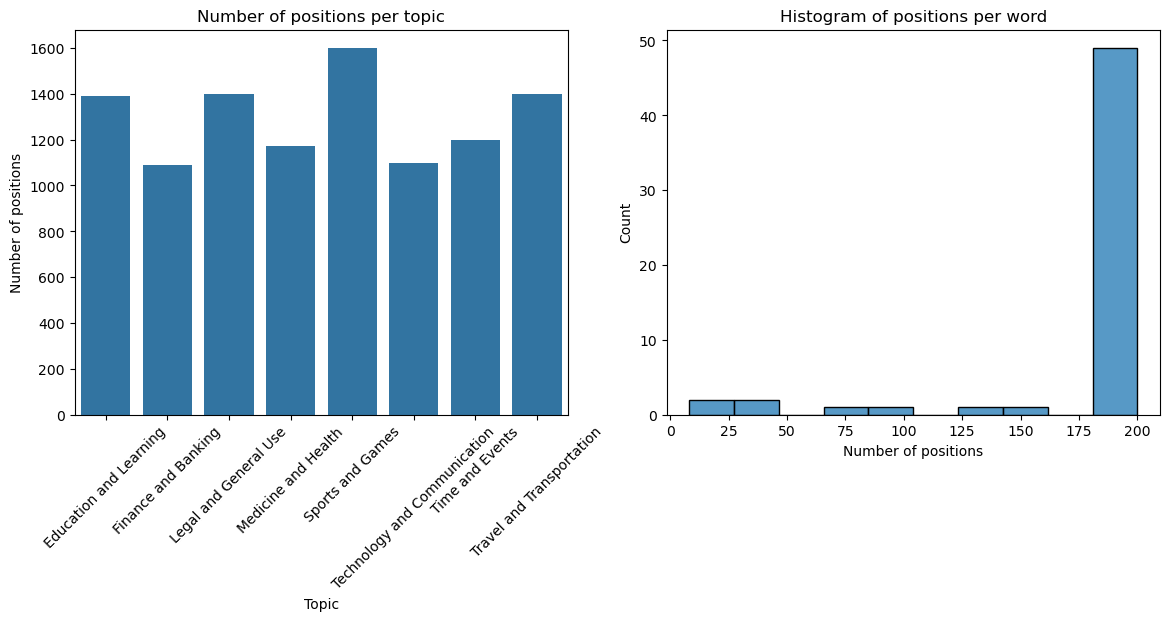

In [64]:
# 2 subsplots side-by-side: (i) bar chart showing number of positions per topic, 
# (ii) histogram of positions per word

# show words with 0 positions
target_tokens = list(word_to_topic.keys())
target_tokens_with_positions = positions['token'].unique()
target_tokens_without_positions = [token for token in target_tokens if token not in target_tokens_with_positions]
n = len(target_tokens_without_positions)
m = len(target_tokens)
print (f"{n} out of {m} words ({n/m*100:.2f}%) do not have positions")
print (f"Words without positions: {target_tokens_without_positions}")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x='topic', y='index', data=positions.groupby('topic').agg({'index': 'count'}).reset_index(), ax=ax[0])
ax[0].set_title('Number of positions per topic'); ax[0].set_xlabel('Topic'); ax[0].set_ylabel('Number of positions')
# rotate x-axis labels
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

num_positions_per_word = positions.groupby('token').agg({'index': 'count'}).reset_index()
sns.histplot(num_positions_per_word['index'], ax=ax[1], bins=10)
ax[1].set_title('Histogram of positions per word'); ax[1].set_xlabel('Number of positions'); ax[1].set_ylabel('Count')
plt.show()

In [66]:
target_token_embeddings = []
for root_dir_idx in range(len(roots_with_data)):
    segment_data = positions[positions['root_dir_idx'] == root_dir_idx].copy()
    index_positions = segment_data['index'].values
    embeddings = np.load(f'local/thread_{root_dir_idx}_output/concatenated_embeddings.npy')[index_positions]
    segment_data['embeddings'] = list(embeddings)
    target_token_embeddings.append(segment_data)

target_token_embeddings = pd.concat(target_token_embeddings)

In [67]:
target_token_embeddings

,sid,pos,token,index,root_dir_idx,topic,embeddings
63,0-0,63,note,63,0,Time and Events,"[-0.4973, 0.135, 0.08014, 0.03946, -0.16, -0.1..."
1132,0-3,113,class,1132,0,Education and Learning,"[-0.0649, -0.2389, -0.2465, -0.02313, 0.0946, ..."
1783,0-6,44,goal,1783,0,Sports and Games,"[-0.002043, 0.219, 0.2795, 0.0462, 0.441, 0.02..."
1912,0-6,173,interest,1912,0,Time and Events,"[-0.2491, -0.1444, 0.6875, -0.1866, 0.7383, 0...."
3796,0-13,144,term,3796,0,Education and Learning,"[-0.665, -0.6006, 0.2242, 0.1026, -0.2394, -0...."
...,...,...,...,...,...,...,...
13653785,9-4265,19,capital,1174373,9,Finance and Banking,"[-0.3381, 0.4104, 0.1661, 0.2201, -0.694, 0.23..."
13658891,9-4286,188,flight,1179479,9,Travel and Transportation,"[0.3262, -0.3308, 0.2893, 0.187, -0.0726, -0.1..."
13661719,9-4295,224,port,1182307,9,Travel and Transportation,"[0.2266, -0.3215, 0.57, -0.1037, -0.0693, 0.72..."
13662693,9-4299,144,port,1183281,9,Travel and Transportation,"[0.05716, -0.861, 0.5933, -0.2131, -0.1198, 0...."


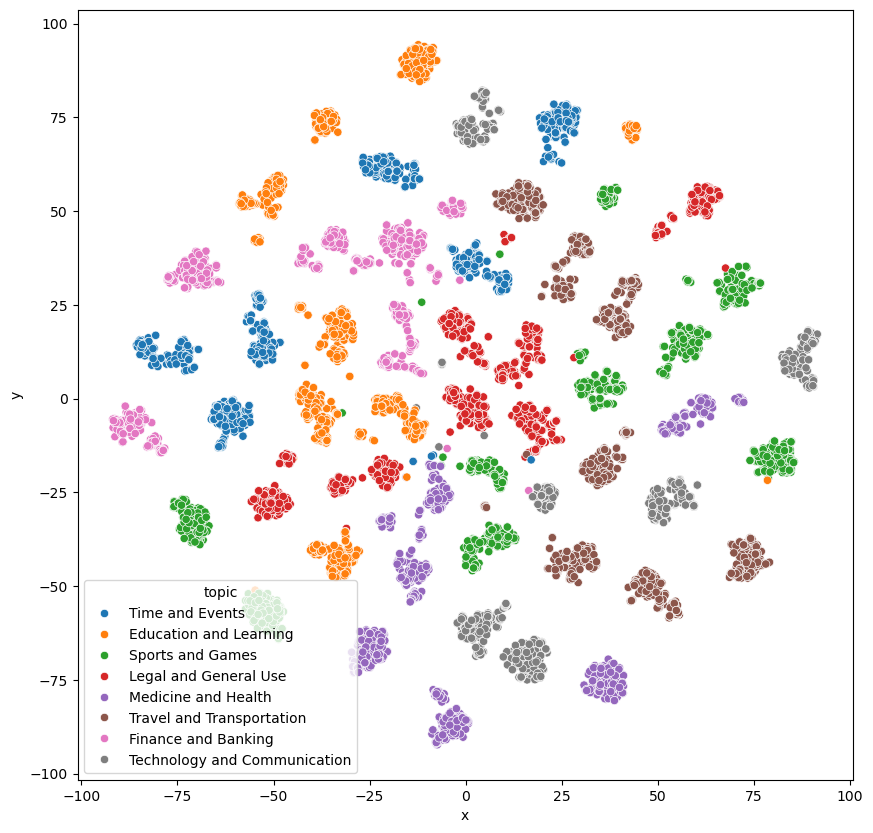

In [68]:
# use tsne to visualize the embeddings

tsne = TSNE(n_components=2)
embeddings = np.array(target_token_embeddings['embeddings'].values.tolist())

tsne_embeddings = tsne.fit_transform(embeddings)

tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y'])
tsne_df['topic'] = target_token_embeddings['topic'].values
tsne_df['token'] = target_token_embeddings['token'].values

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='topic')
plt.show()

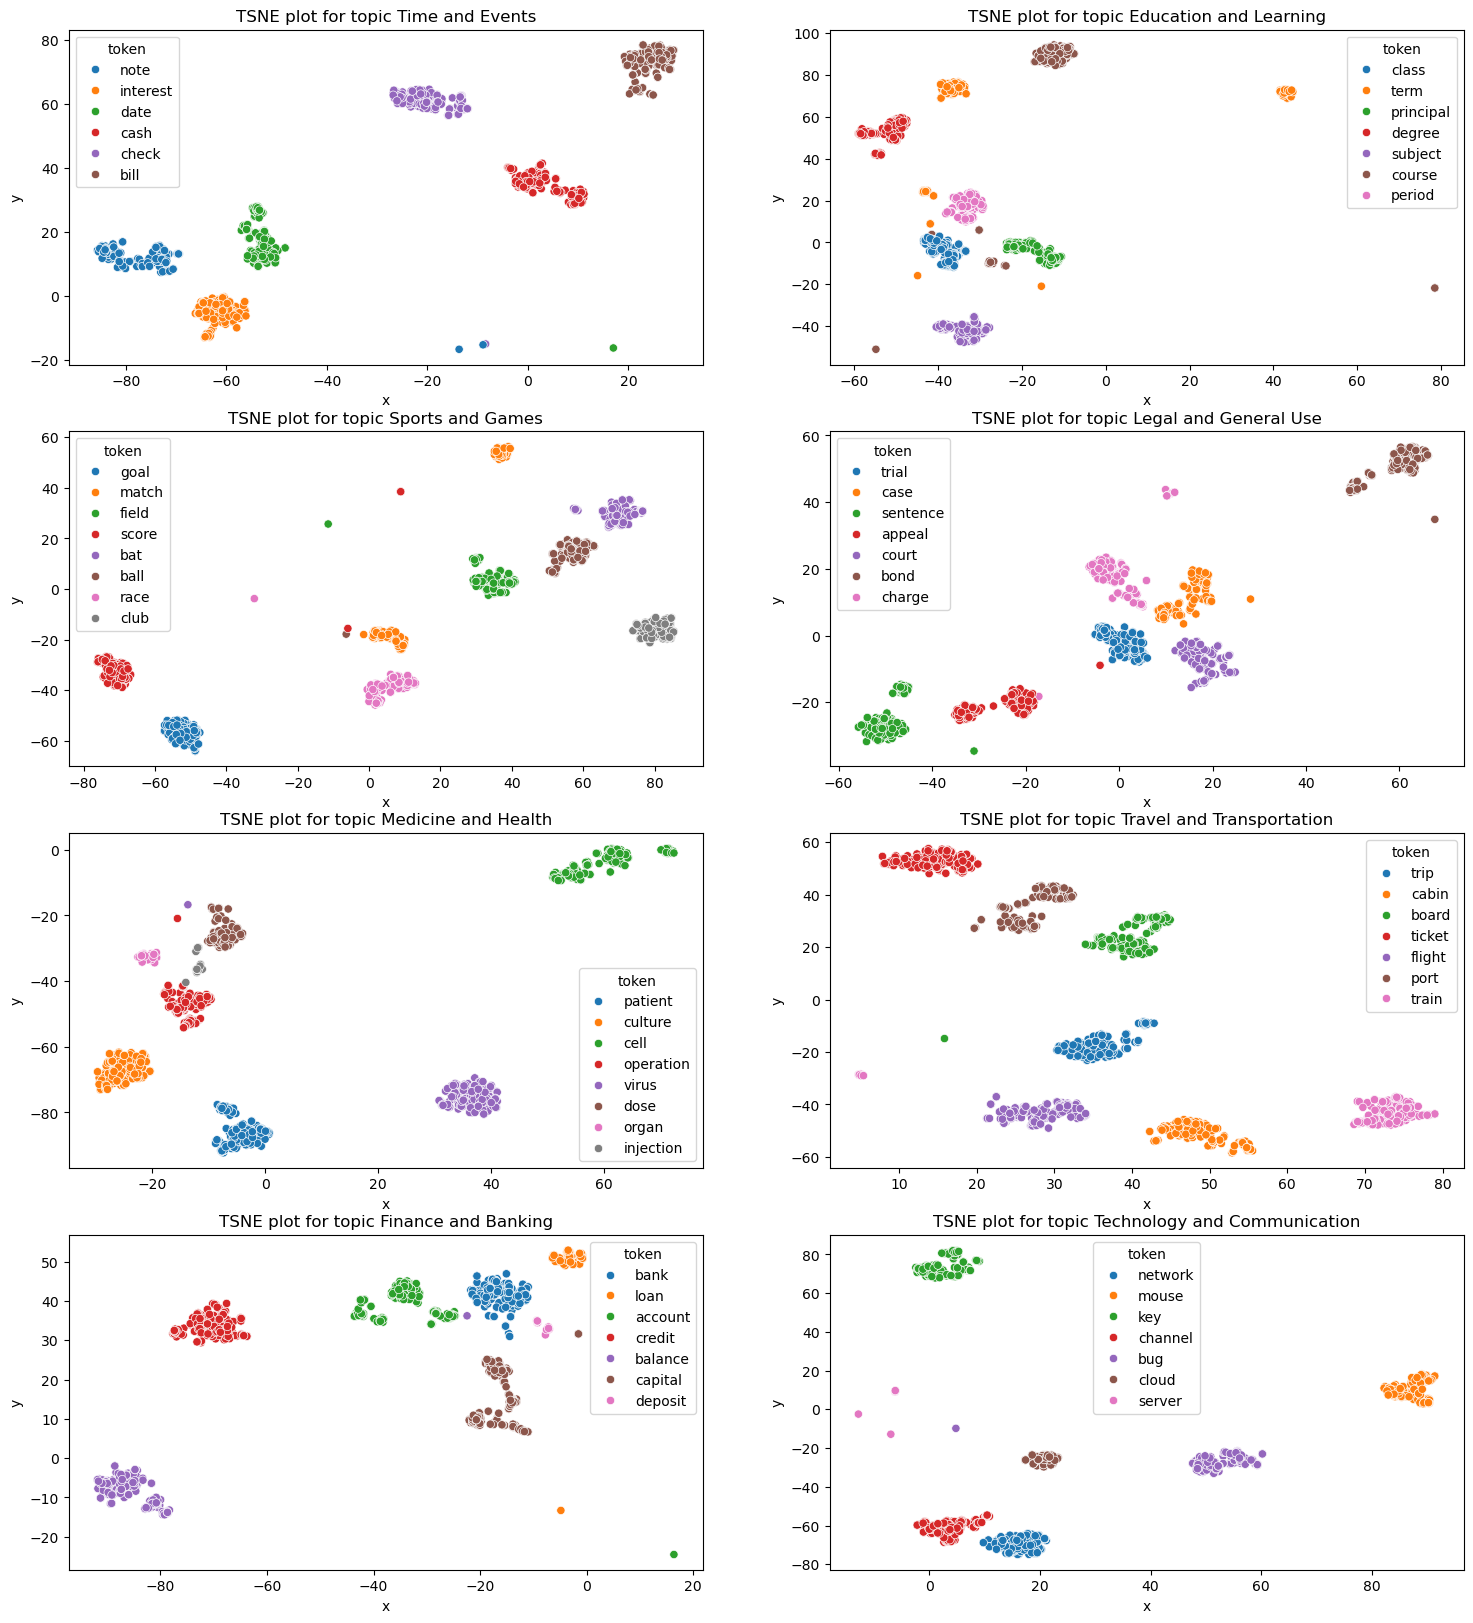

In [72]:
# create a 4x2 grid of plots where each plot is the tsne plot for a topic

"""
Words are extremely well segregated, which would make sense as the pretraining task is to classify them from masked context.
"""

topics = tsne_df['topic'].unique()
n = len(topics)

fig, ax = plt.subplots(n//2, 2, figsize=(18, 5*n//2))
for i, topic in enumerate(topics):
    sns.scatterplot(data=tsne_df[tsne_df['topic'] == topic], x='x', y='y', hue='token', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'TSNE plot for topic {topic}')
plt.show()

In [202]:
def kmeans_clustering_function_generator(n):
    return KMeans(n_clusters=n, n_init='auto')
    
def deep_dive_target_word(target_word, N, 
                          target_token_embeddings=target_token_embeddings,
                          clustering_function_generator=kmeans_clustering_function_generator):
    pdf = target_token_embeddings[target_token_embeddings['token'] == target_word].copy()
    embs = np.array(pdf['embeddings'].values.tolist())

    # run clusterer on the embeddings
    # find optimal number of clusters using silhouette score
    silhouette_scores = []
    for n_clusters in range(2, 11):
        clusterer = clustering_function_generator(n_clusters)
        clusterer.fit(embs)
        silhouette_scores.append(silhouette_score(embs, clusterer.labels_))

    plt.plot(range(2, 11), silhouette_scores)
    plt.title('Silhouette score for different number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    clusterer = clustering_function_generator(N)
    clusterer.fit(embs)

    pdf['cluster'] = clusterer.labels_

    # visualize the clusters using tsne
    embs2 = tsne.fit_transform(embs)
    pdf['x'] = embs2[:, 0]
    pdf['y'] = embs2[:, 1]

    plt.figure(figsize=(5, 5))
    sns.scatterplot(x='x', y='y', hue='cluster', data=pdf)
    plt.title(f'clustering for word {target_word}')
    plt.show()

    # lets look at how the word was used in these 2 clusters
    for cluster in range(N):
        cluster_pdf = pdf[pdf['cluster'] == cluster][['sid', 'pos']].copy()
        print (f"Cluster {cluster} (size = {len(cluster_pdf)})")

        locations = cluster_pdf.sample(min(5, len(cluster_pdf)))
        
        # print 15 words before and after the positions in each locations
        for location in locations.iterrows():
            sid, pos = location[1]
            row = sentence_pdf[sentence_pdf['sid'] == sid].iloc[0]
            full_text = row['text']
            tokens = eval(row['tokens'])
            start = max(0, pos-15)
            end = min(len(tokens), pos+15)
            print (f"...{' '.join(tokens[start:pos])} @@{''.join(tokens[pos])}@@ {' '.join(tokens[pos+1:end])}...")
        print ()

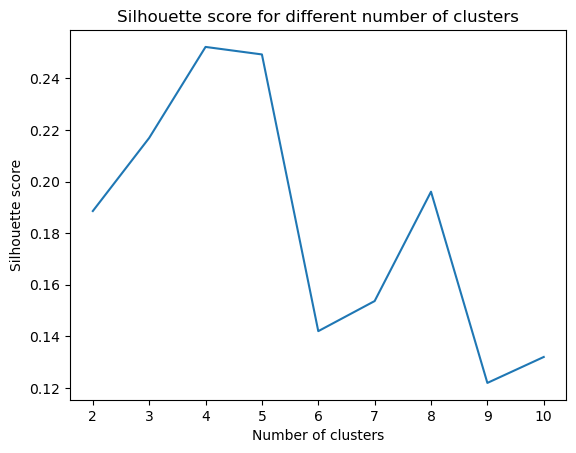

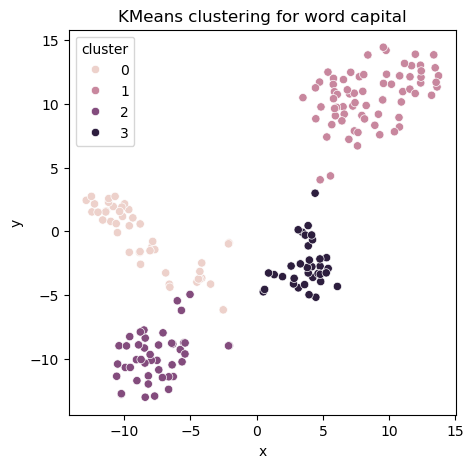

Cluster 0 (size = 46)
...is particularly interesting as time and again it has been proved that strict laws and @@capital@@ punishments have not been able to prevent homicide . [SEP]...
...robert blake and scott wilson and first time in a movie a sad comment about @@capital@@ punishment at the last moments before their deaths . jones , hall and brooks...
...> < br / > an interesting , and maybe the first , look at @@capital@@ punishment , and what ends we hope to achieve . is this nothing more...
...shoots the thief right in the back , to applause from the watching crowd . @@capital@@ punishment for theft ? well , okay . the attitude of everyone in the...
...br / > brilliant ! what a great idea . the movie makers get some @@capital@@ to do the movie with , thanks to their cast and crew . then...

Cluster 1 (size = 72)
...movie , they ' ve created a fictional horror film in which they tried to @@capital@@ ##ize on the true story in order to sell a cheap , poorly acted...
...for another m

In [159]:
deep_dive_target_word('capital', 4)

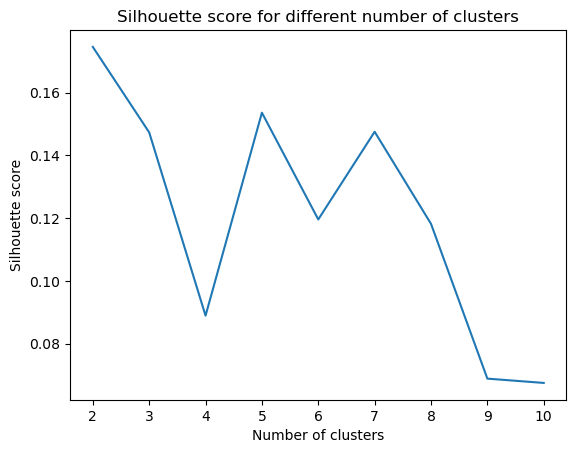

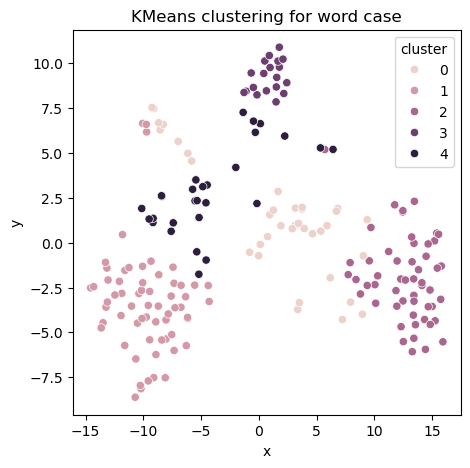

Cluster 0 (size = 38)
...pose ##idon adventure " ( 1972 ) , you may experience nothing more than a @@case@@ of the ' bends ' . this film offers nothing more than two extremely...
...) this movie slides slowly into disaster . there ' s a guru ( robert @@case@@ ) who talks nonstop about nothing of any importance . i wanted to gag...
...co ##gna ##c ! ! ! ! ! i went out after and bought a @@case@@ of co ##gna ##c ! ! ! ! ! i went out after and...
...< br / > maybe this film wants to remind of these basic facts in @@case@@ it should ever happen to one of us . why the long walk in...
..., find i cannot even think of that moment without being hit with a severe @@case@@ of " i ' ve got something in my eye . " in fact...

Cluster 1 (size = 62)
...find people who could sing when making a musical , right ? not in this @@case@@ . luckily they were half talking / half singing in rhyme most of the...
...does not have an age limit to be able to enjoy it . so in @@case@@ you haven ' t seen it and wil

In [160]:
deep_dive_target_word('case', 5)

In [190]:
"""
kmeans is working okay but the cluster assignments are noisy. Specially when the cluster sizes vary a lot which seems to be the case here.
"""
_=1

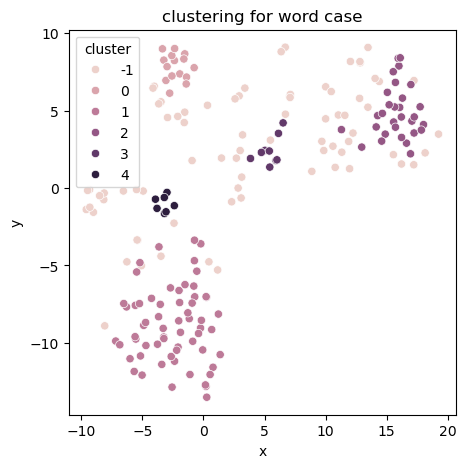

Cluster 0 (size = 15)
.... < br / > < br / > unfortunately , this was not the @@case@@ , so when watching the film , and seeing the poor story and acting...
...' m glad i read ( twice ) the book first which is usually the @@case@@ for me . i know that one must view a novel and a film...
...the characters had inconsistent and unbelievable motivation ##s , and unfortunately that was also the @@case@@ with dead letter office . hopefully this movie will end up in the dead...
...tom , crow and the others from ms ##t ##3 ##k . so was the @@case@@ with this one as well and even though i found the movie in itself...
...##is ##co ##vered gem did make it into his vc ##r - this being the @@case@@ with this film . everything about the film is good , but much more...

Cluster 1 (size = 62)
...but de ##pressing doesn ' t necessarily have to mean bad . unfortunately in this @@case@@ it is in fact pretty bad . the film has some good things going...
...##te himself , it ' s done , he moves on . but in 

In [174]:
# lets try with DBSCAN instead

target_word = 'case'

pdf = target_token_embeddings[target_token_embeddings['token'] == target_word].copy()
embs = np.array(pdf['embeddings'].values.tolist())

clusterer = DBSCAN(eps=6)
clusterer.fit(embs)

pdf['cluster'] = clusterer.labels_

# visualize the clusters using tsne
embs2 = tsne.fit_transform(embs)
pdf['x'] = embs2[:, 0]
pdf['y'] = embs2[:, 1]

plt.figure(figsize=(5, 5))
sns.scatterplot(x='x', y='y', hue='cluster', data=pdf)
plt.title(f'clustering for word {target_word}')
plt.show()

# lets look at how the word was used in these 2 clusters
for cluster in range(len(pdf['cluster'].unique())):
    cluster_pdf = pdf[pdf['cluster'] == cluster][['sid', 'pos']].copy()
    print (f"Cluster {cluster} (size = {len(cluster_pdf)})")

    locations = cluster_pdf.sample(min(5, len(cluster_pdf)))
    
    # print 15 words before and after the positions in each locations
    for location in locations.iterrows():
        sid, pos = location[1]
        row = sentence_pdf[sentence_pdf['sid'] == sid].iloc[0]
        full_text = row['text']
        tokens = eval(row['tokens'])
        start = max(0, pos-15)
        end = min(len(tokens), pos+15)
        print (f"...{' '.join(tokens[start:pos])} @@{''.join(tokens[pos])}@@ {' '.join(tokens[pos+1:end])}...")
    print ()

In [191]:
"""
dbscan is also not too great. Boundary points are quickly merging clusers. Clusters are not very well separated in the data.
"""
_=1

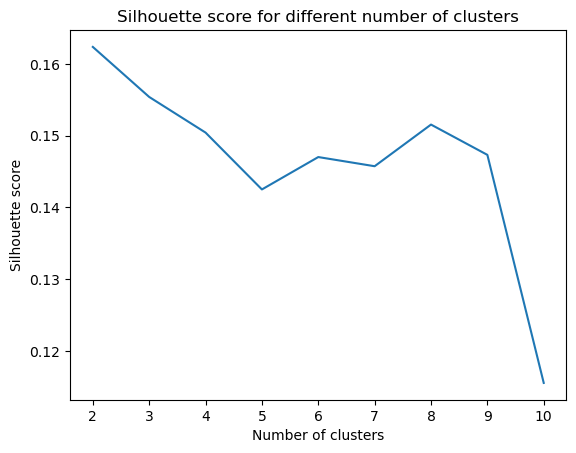

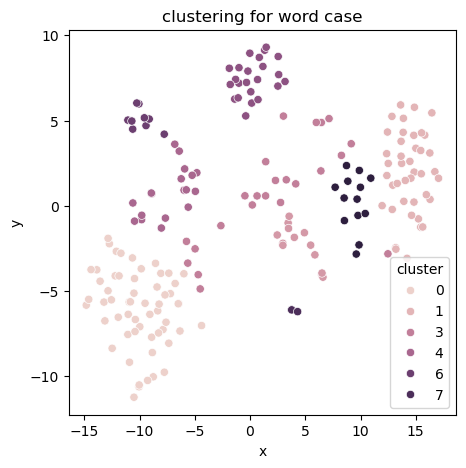

Cluster 0 (size = 57)
...kris ##to ##ffer ##son , which doesn ' t work at all . in either @@case@@ jackie g ##lea ##son is a much better actor for this type of role...
...made movie , when the same - language - speaking foreigners ( russians in this @@case@@ ) are left alone , they prefer to communicate with each other mostly in...
...with " tailored " rules or was a " fantastic " world but in this @@case@@ no accidents like people remembering how it was before can happen . < br...
...it ' s a formula that is used a lot . but , in this @@case@@ it is for ##gi ##vable because even though they use puppets for some characters...
...anything right without dumb ##ing it down and adding a happy ending . in this @@case@@ , they just changed it completely , cheap ##ening an important and realistic story...

Cluster 1 (size = 41)
...' t recall any based on a true story disc ##lai ##mer , but the @@case@@ does have mo ##w written all over it . apparently it chronicles the real...
...italian gang

In [180]:
# agglomerative clustering
# wow! this is working really well!!!

def agglomerative_clustering_function_generator(n):
    return AgglomerativeClustering(n_clusters=n, linkage='ward', metric='euclidean')

deep_dive_target_word('case', 9, clustering_function_generator=agglomerative_clustering_function_generator)

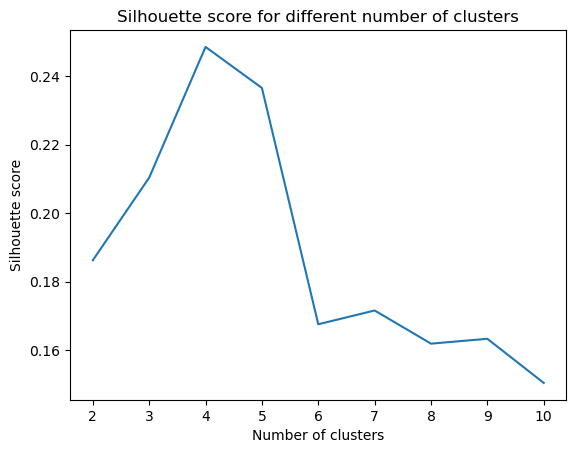

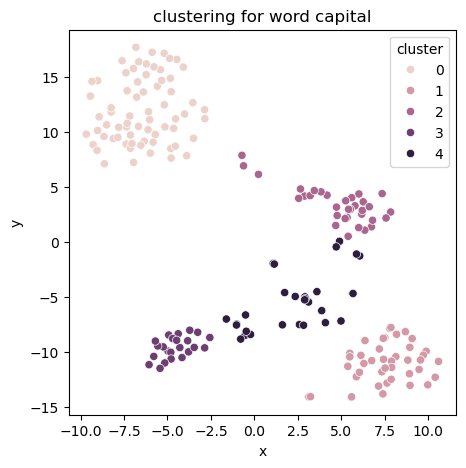

Cluster 0 (size = 70)
...[CLS] the sect ##s that @@capital@@ ##ise on this film are well known for their claim to take the '...
...player that this film completely ignored . shame on the makers of this film for @@capital@@ ##izing on his faults and not his great ##ness . [SEP]...
...[CLS] this game is from a genre of games that tried to @@capital@@ ##ize off of the whole my ##st - inspired trend - - walk around...
...see this movie . it ' s simply a 100 minute nintendo commercial designed to @@capital@@ ##ize on the power ##gl ##ove , the legend of ze ##lda and super...
...that it didn ' t have the star power of fra ##iser as george they @@capital@@ ##ized on the humor and i believe show ##eman did pretty well as the...

Cluster 1 (size = 43)
...> < br / > most of the story presents the sad side of the @@capital@@ city . it shows many different nationality background . many of it , make...
...[CLS] i agree that @@capital@@ city should be on dvd . i watched this show only by accident in

In [182]:
deep_dive_target_word('capital', 5, clustering_function_generator=agglomerative_clustering_function_generator)

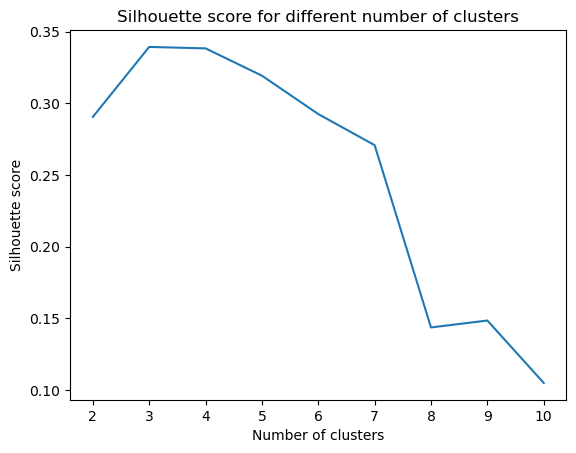

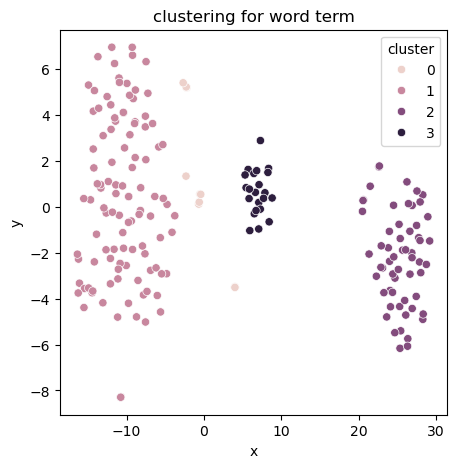

Cluster 0 (size = 12)
..., right ? ) . she manipulate ##s the poor desperate fool into writing her @@term@@ paper on shakespeare , which the teacher immediately knows she couldn ' t have...
...dan reed for trying , i have no issue with his directing abilities but in @@term@@ of writing . . . i ' d say next time he should stick...
...think it ' s better than sep ##et and much better than gu ##bra in @@term@@ of its story , its sentimental value . < br / > < br...
.... < br / > < br / > this movie would make a great @@term@@ paper in college philosophy 101 . if you ' re board out of your...
...ve always enjoyed frank sinatra ' s music , and just recently i wrote a @@term@@ paper about his life story . i ' ve been fascinated by the life...

Cluster 1 (size = 108)
...as ##tral body " , and don ' t mind the frequent use of the @@term@@ " energy " outside of the context of physics or technology , you might...
...horror and the supernatural , and romance elements in the contemporary sense of 

In [188]:
deep_dive_target_word('term', 4, clustering_function_generator=agglomerative_clustering_function_generator)

In [193]:
"""
Clusters kind of look like they are gaussian distributions. GMM might work well here.
Also, I forgot to normalize the embeddings. May be that is messing with the kmeans clustering as well.

Lets first analyse the embeddings by looking at norms and distributions of each dimension.
"""
_=1

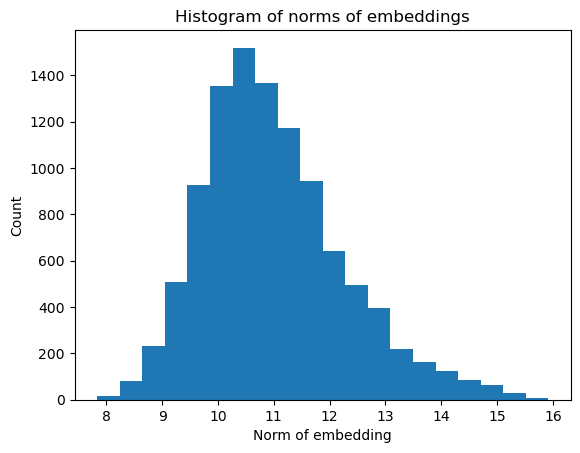

Mean variance in each dimension: 0.08160400390625, median: 0.0711669921875


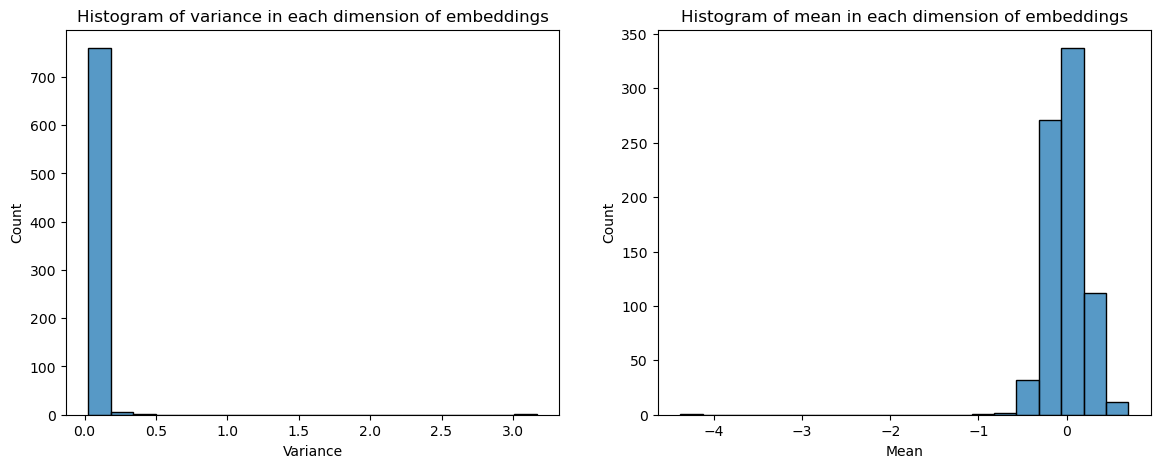

In [201]:
raw_embs = np.array(target_token_embeddings['embeddings'].values.tolist())

# plot the histogram of norms of embeddings and histogram of variance and mean in each dimension
norms = np.linalg.norm(raw_embs, axis=1)
plt.hist(norms, bins=20); plt.title('Histogram of norms of embeddings'); plt.xlabel('Norm of embedding'); plt.ylabel('Count'); plt.show()

variances = np.var(raw_embs, axis=0)
print (f"Mean variance in each dimension: {np.mean(variances)}, median: {np.median(variances)}")
means = np.mean(raw_embs, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(variances, ax=ax[0], bins=20)
ax[0].set_title('Histogram of variance in each dimension of embeddings'); ax[0].set_xlabel('Variance'); ax[0].set_ylabel('Count')
sns.histplot(means, ax=ax[1], bins=20)
ax[1].set_title('Histogram of mean in each dimension of embeddings'); ax[1].set_xlabel('Mean'); ax[1].set_ylabel('Count')
plt.show()

In [205]:
"""
Most dimensions are centered around 0 and small variance but some dimensions have large variance
or not centered around 0. norms look look like they are gaussian distributed.

These must be the "rogue dimensions" that the nlp book mentioned.

Since we're trying to cluster the embeddings, lets try to standardize them as suggested by the NLP book.
"""
_=1

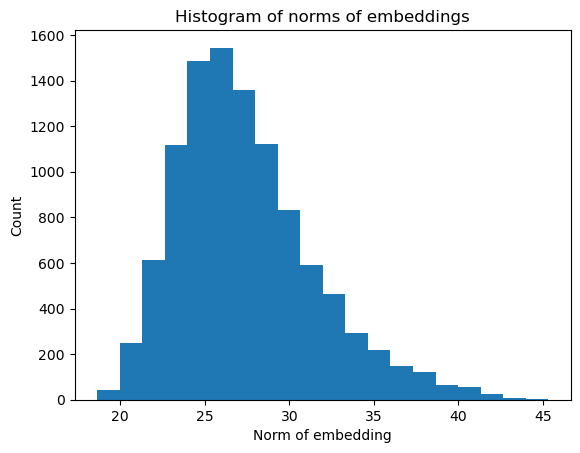

Mean variance in each dimension: 0.79052734375, median: 0.79150390625


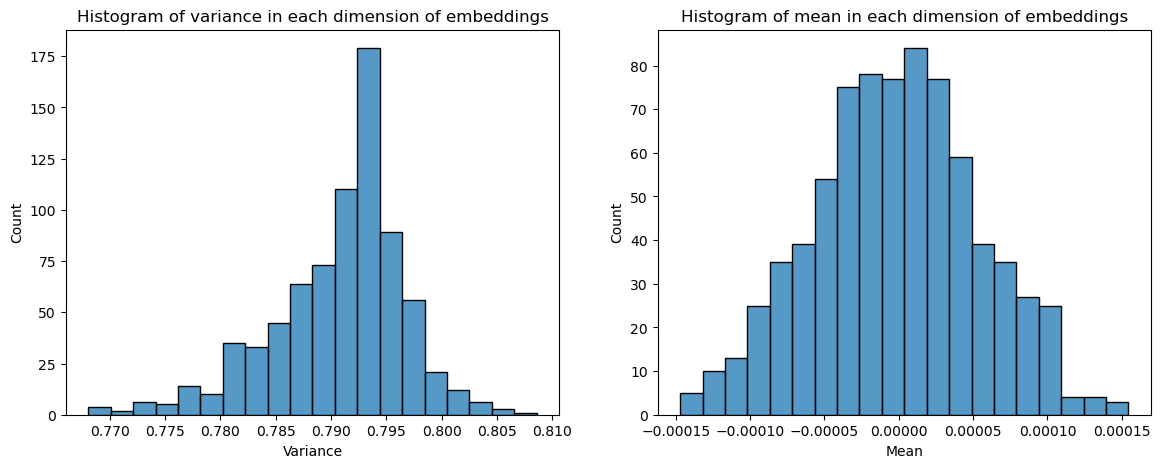

In [209]:
raw_embs = np.array(target_token_embeddings['embeddings'].values.tolist())

scaler = StandardScaler()
scaler.fit(raw_embs)
standardized_embs = scaler.transform(raw_embs)

new_target_token_embeddings = target_token_embeddings.copy()
new_target_token_embeddings['embeddings'] = list(standardized_embs)

# lets again plot the histograms of norms and variance and mean in each dimension
norms = np.linalg.norm(standardized_embs, axis=1)
plt.hist(norms, bins=20); plt.title('Histogram of norms of embeddings'); plt.xlabel('Norm of embedding'); plt.ylabel('Count'); plt.show()

variances = np.var(standardized_embs, axis=0)
print (f"Mean variance in each dimension: {np.mean(variances)}, median: {np.median(variances)}")
means = np.mean(standardized_embs, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(variances, ax=ax[0], bins=20)
ax[0].set_title('Histogram of variance in each dimension of embeddings'); ax[0].set_xlabel('Variance'); ax[0].set_ylabel('Count')
sns.histplot(means, ax=ax[1], bins=20)
ax[1].set_title('Histogram of mean in each dimension of embeddings'); ax[1].set_xlabel('Mean'); ax[1].set_ylabel('Count')
plt.show()

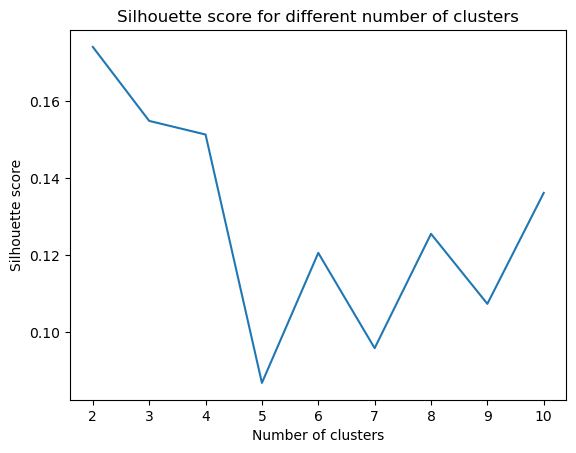

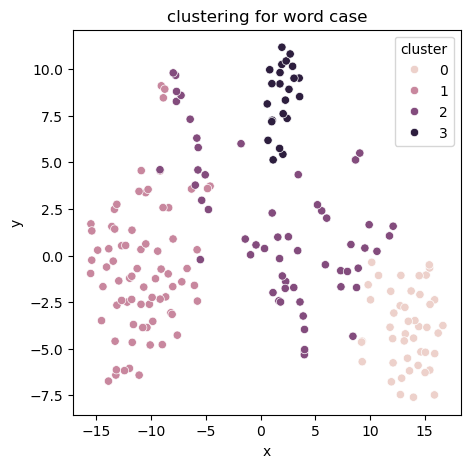

Cluster 0 (size = 45)
...movie ) have been murdered , why is there only one investigator working on the @@case@@ ? why did the investigator suddenly decide that he should go look for seed...
...doing their job only too well . . the movie contained within the little plastic @@case@@ is as bad as it sounds , and then some . < br /...
...the diplomat freaks out and " kills " the guy , leading into a murder @@case@@ . he and his fia ##ce ##e decide to find the girl they had...
...dangerous for that matter . the concept of the film is based on an actual @@case@@ of fraud that still has yet to be officially confirmed . in high school...
...microphone ##s or inconsistent quality ( such as what was seen in the bishop murder @@case@@ , hell ' s angels and other films of the day ) . this...

Cluster 1 (size = 74)
...that we aren ' t supposed to take the movie seriously , but in any @@case@@ it ' s a sham ##bles . < br / > < br /...
...lines are clearly not intended to be taken seriously but deli

In [218]:
# lets try kmeans again on the standardized embeddings
# looks the same to me
deep_dive_target_word('case', 4, 
                      target_token_embeddings=new_target_token_embeddings, 
                      clustering_function_generator=kmeans_clustering_function_generator)

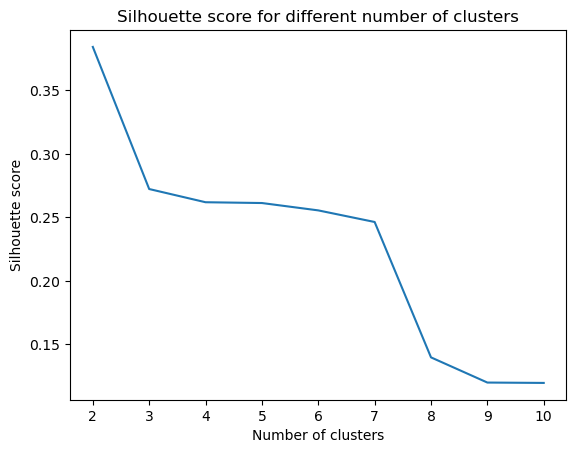

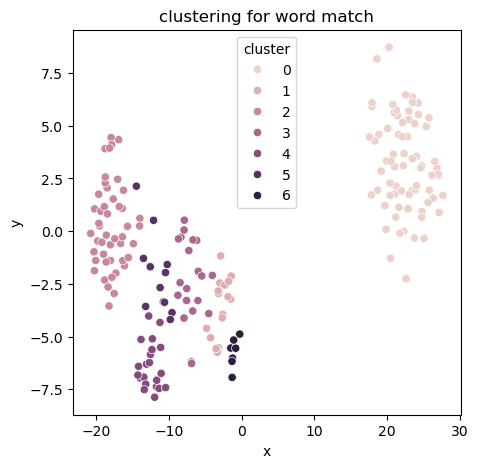

Cluster 0 (size = 75)
...continue . < br / > < br / > teddy long announces a new @@match@@ for the tag team titles : london and kendrick will defend against : regal...
...especially considering the shape that his back was in and that this was his last @@match@@ . [SEP]...
...> < br / > immunity battle royal : this was an outstanding ##ly fun @@match@@ to watch , but because the main stars of both companies were involved in...
...ashley and the woman ' s championship was also on the line . in a @@match@@ , i thought would have been left to brew till wrestlemania 22 mick ##ie...
...team belts from ha ##ku and andre the giant , the first ever mixed tag @@match@@ featuring randy savage and sensation ##al queen she ##rri vs dusty rhodes and the...

Cluster 1 (size = 17)
...their own right . the background layer is important once the golf match becomes a @@match@@ using minds as well as golf clubs , since you get a good understanding...
...cage ' and putting them in a random generator ! sayi

In [220]:
"""
Why is cluster 0 so well seperated with others whereas others are kind of mushed together?
"""
deep_dive_target_word('match', 7, 
                      target_token_embeddings=new_target_token_embeddings, 
                      clustering_function_generator=agglomerative_clustering_function_generator)

In [223]:
# lets try GMM now. It looks like the embeddings are gaussian distributed

class MyGMMClusterer:
    # implements interface expected by deep_dive_target_word function
    def __init__(self, gaussian_mixture):
        self.gaussian_mixture = gaussian_mixture
    
    def fit(self, embs):
        self.gaussian_mixture.fit(embs)
        self.labels_ = self.gaussian_mixture.predict(embs)

def gmm_clustering_function_generator(n):
    return MyGMMClusterer(GaussianMixture(n_components=n, n_init=10))


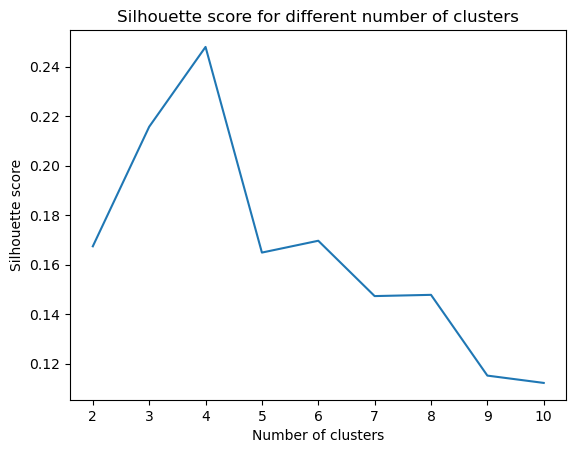

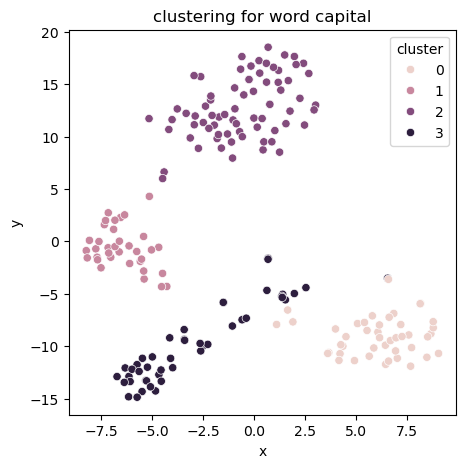

Cluster 0 (size = 44)
...twins meet a fabulous french model because they ' re in paris , the fashion @@capital@@ of the world . they make bf ##fs with the model and spend a...
...few months ago when it ran for the first time ( even in metropolitan movie @@capital@@ l . a . ! ) for a couple of weeks and then disappeared...
...industry ( - to say nothing of ugly betty ) , that it ' s @@capital@@ , bogota ( pop . 9 million ) is the " world capital of...
...looking giant tentacles look real , which is hilarious to behold ; bulgaria ' s @@capital@@ , sofia , un ##con ##vin ##cing ##ly stands in for new york ,...
...' s madison avenue , best known in the 1960 ' s as the advertising @@capital@@ of the world . members of generation x and y may be lost on...

Cluster 1 (size = 35)
...ostensibly a comedy , is deadly serious . its subject is imperialism ( with a @@capital@@ i ) : how britain , foolish ##ly , humiliating ##ly , tries to...
...> < br / > this is a lavish production with , yes , a @

In [225]:
deep_dive_target_word('capital', 4,
                        target_token_embeddings=new_target_token_embeddings, 
                        clustering_function_generator=gmm_clustering_function_generator)

In [226]:
# working well! Though it looks like there are lot of smaller clusters which are not as aparent due to small sample size